In [2]:
from pathlib import Path
import pandas as pd
import trompy as tp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

%matplotlib inline

In [3]:
DATAFOLDER = Path("../data")
FIGSFOLDER = Path("../figures")

In [5]:
df = pd.read_csv(DATAFOLDER / 'fig_4_protein_intake.csv')
print(df.head())

       ID   sex group  week_0  week_1  week_2  week_3  week_4  week_5  week_6  \
0  MPX301  male    NR    0.65    0.54    0.49    0.54    0.41    0.43    0.44   
1  MPX302  male    NR    0.32    0.51    0.41    0.44    0.47    0.50    0.58   
2  MPX303  male   IPR    0.38    0.11    0.58    0.13    0.65    0.12    0.65   
3  MPX304  male   IPR    0.59    0.12    0.45    0.13    0.48    0.11    0.67   
4  MPX305  male    PR    0.56    0.13    0.11    0.13    0.14    0.13    0.13   

   week_7  week_8  avg_weeks_IPR_on_PR_diet  avg_weeks_IPR_on_NR_diet  
0    0.57    0.36                      0.52                      0.42  
1    0.53    0.58                      0.50                      0.51  
2    0.13    0.65                      0.12                      0.63  
3    0.12    0.63                      0.12                      0.56  
4    0.12    0.12                      0.13                      0.13  


In [9]:
# Melt the DataFrame to long format
df_long = df.melt(id_vars=['ID', 'sex', 'group'], 
                  value_vars=['week_0', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8'],
                  var_name='week', 
                  value_name='protein intake')

# Convert 'week' to a numeric value for easier plotting
df_long['week'] = df_long['week'].str.extract('(\d+)').astype(int)

# Calculate mean and SEM
df_stats = df_long.groupby(['sex', 'group', 'week']).agg(
    mean_protein_intake=('protein intake', 'mean'),
    sem_protein_intake=('protein intake', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Filter by sex
df_male_stats = df_stats[df_stats['sex'] == 'male']
df_female_stats = df_stats[df_stats['sex'] == 'female']


In [10]:
df_males = df[df['sex'] == 'male']
df_females = df[df['sex'] == 'female']

In [11]:
avg_weeks_IPR_on_PR_diet_males = df_males.groupby('group')['avg_weeks_IPR_on_PR_diet'].apply(list).to_dict()
avg_weeks_IPR_on_NR_diet_males = df_males.groupby('group')['avg_weeks_IPR_on_NR_diet'].apply(list).to_dict()

avg_weeks_IPR_on_PR_diet_females = df_females.groupby('group')['avg_weeks_IPR_on_PR_diet'].apply(list).to_dict()
avg_weeks_IPR_on_NR_diet_females = df_females.groupby('group')['avg_weeks_IPR_on_NR_diet'].apply(list).to_dict()

In [12]:
def create_barscatter(ax, data_baseline_values, data_end_values):
    tp.barscatter(
        [[data_baseline_values["NR"], data_end_values["NR"]], 
         [data_baseline_values["PR"], data_end_values["PR"]],
         [data_baseline_values["IPR"], data_end_values["IPR"]]],
        paired=True,
        barfacecolor_option='individual',
        barfacecolor=[color for group in group_labels for color in colors[group]],
        scattersize=scattersize,
        grouplabel=group_labels,
        scatteralpha=0.6,
        fontsize=12,
        ax=ax)

In [13]:
colors = {'NR': ["#FF7F0E", "#ffb370"],
          'PR': ["#9467BD", "#c4abdb"],
          'IPR': ["#17BECF", "#90eaf3"]}

first_colors = {group: color_list[0] for group, color_list in colors.items()}

markers = {'NR': "o",
          'PR': "D",
          'IPR': "v"}

group_labels = ["NR", "PR", "IPR"]
scattersize=50

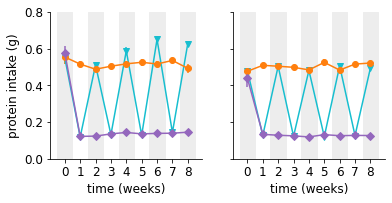

In [16]:
# PROTEIN INTAKE OVER TIME
f,ax=plt.subplots(figsize=(6, 3),ncols=2, sharey=True, gridspec_kw={"bottom": 0.2})

for group in df_male_stats['group'].unique():
    subset = df_male_stats[df_male_stats['group'] == group]
    ax[0].errorbar(subset['week'], subset['mean_protein_intake'], yerr=subset['sem_protein_intake'],
                 label=group, color=first_colors[group], marker=markers[group])

for group in df_female_stats['group'].unique():
    subset = df_female_stats[df_female_stats['group'] == group]
    ax[1].errorbar(subset['week'], subset['mean_protein_intake'], yerr=subset['sem_protein_intake'],
                 label=group, color=first_colors[group], marker=markers[group])
    

#grey for weeks when IPR is on NR diet    
x_ranges = [(-0.5, 0.5), (1.5, 2.5), (3.5, 4.5), (5.5, 6.5), (7.5, 8.5)]

for subplot in ax:
    for start, end in x_ranges:
        subplot.axvspan(start, end, color='#ededed')

        
ax[0].set_ylim(0,0.8)

ax[0].set_ylabel("protein intake (g)", fontsize = 12)

for ax in [ax[0],ax[1]]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('time (weeks)', fontsize = 12)
    ax.set_xticks([0,1,2,3,4,5,6,7,8]) 

    
#f.savefig(FIGSFOLDER / "protein_intake.pdf")    

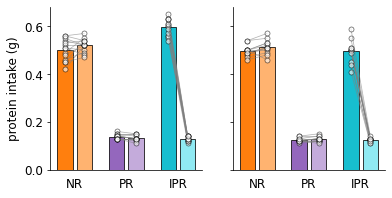

In [17]:
# Protein INTAKE TYPE OF WEEK

f,ax=plt.subplots(figsize=(6, 3),ncols=2, sharey=True)

create_barscatter(ax[0], avg_weeks_IPR_on_NR_diet_males, avg_weeks_IPR_on_PR_diet_males)
create_barscatter(ax[1], avg_weeks_IPR_on_NR_diet_females, avg_weeks_IPR_on_PR_diet_females)


ax[0].set_ylabel("protein intake (g)", fontsize = 12)
for ax in [ax[0],ax[1]]:
    ax.tick_params(axis='both', which='major', labelsize=12)

f.savefig(FIGSFOLDER / "protein_intake_type_of_week.pdf")    